In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

#archive = 'grenoble_2019-11-28_1895981.zip'
archive = 'grenoble_2019-11-30_1896155.zip'

ca8a64e6735b60bc60c49342320befcdeaf55f90


In [2]:
def read_result(name):
    info = archive_extraction.read_yaml(name, 'info.yaml')
    expfile = archive_extraction.read_archive_csv(name, info['expfile'][0])
    result = []
    for i, row in expfile.iterrows():
        tmp = archive_extraction.read_archive_csv(name, 'result_%d.csv' % i)
        for col in expfile.columns:
            tmp[col] = row[col]
        tmp['timestamp'] = pandas.to_datetime(tmp['timestamp'])
        tmp['start'] = tmp['timestamp'] - tmp['timestamp'].min()
        tmp['duration'] *= 1e-9
        result.append(tmp)
    df = pandas.concat(result)
    platform = archive_extraction.get_platform(archive)
    mapping = archive_extraction.platform_to_cpu_mapping(platform)
    df['cpu'] = df.apply(lambda row: mapping[row.core], axis=1)
    return df

df = read_result(archive)
print(len(df))
df.head()

3072000


,timestamp,duration,core,hostname,mask_size,outer_loop,inner_loop,sleep_time,cores,start,cpu
0,2019-11-30 13:06:41.913945320,0.368431,0,dahu-1.grenoble.grid5000.fr,10,1000,250000000,0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,00:00:00.000816,0
1,2019-11-30 13:06:42.282407164,0.429875,0,dahu-1.grenoble.grid5000.fr,10,1000,250000000,0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,00:00:00.369278,0
2,2019-11-30 13:06:42.712287584,0.438832,0,dahu-1.grenoble.grid5000.fr,10,1000,250000000,0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,00:00:00.799158,0
3,2019-11-30 13:06:43.151127738,0.437855,0,dahu-1.grenoble.grid5000.fr,10,1000,250000000,0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,00:00:01.237998,0
4,2019-11-30 13:06:43.588986425,0.437671,0,dahu-1.grenoble.grid5000.fr,10,1000,250000000,0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,00:00:01.675857,0


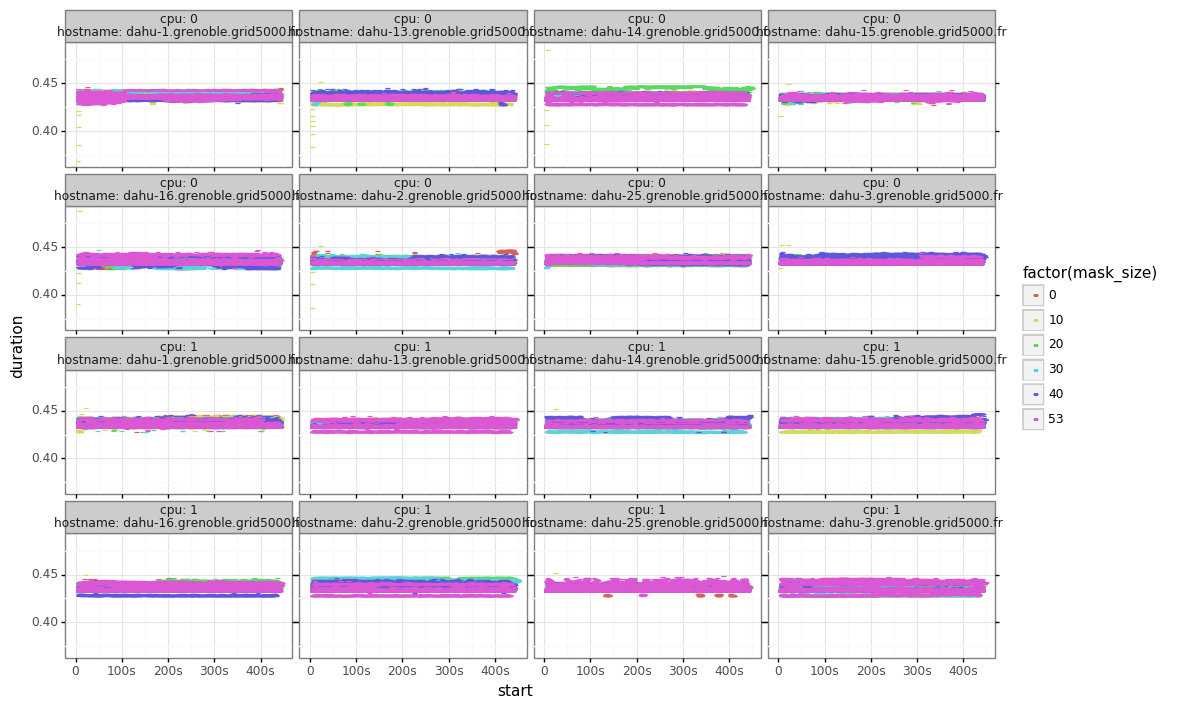

<ggplot: (8728598695474)>

In [3]:
plot = ggplot(df, aes(x='start', y='duration', color='factor(mask_size)')) + geom_point(shape=1) + theme_bw() + facet_wrap(['cpu', 'hostname'], labeller='label_both', nrow=4)
plot

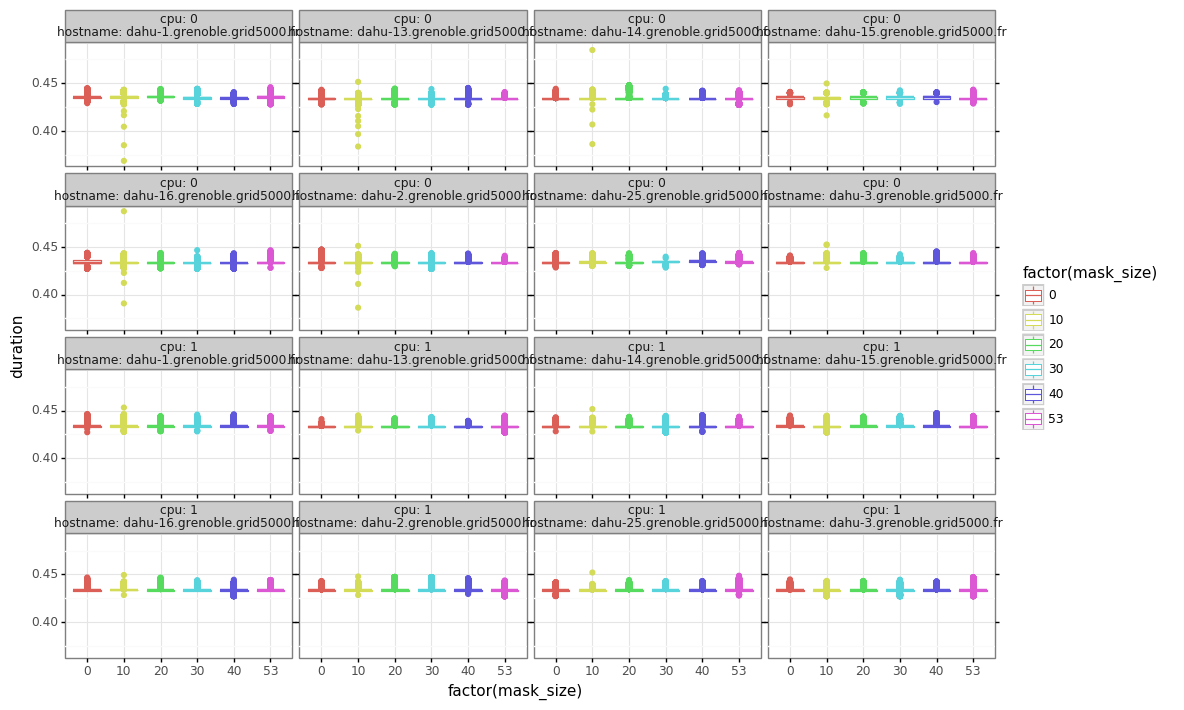

<ggplot: (-9223363308331306208)>

In [4]:
plot = ggplot(df, aes(x='factor(mask_size)', y='duration', color='factor(mask_size)')) + geom_boxplot() + theme_bw() + facet_wrap(['cpu', 'hostname'], labeller='label_both', nrow=4)
plot

In [5]:
df['flop'] = df['inner_loop'] * 4 * 2 * 12
df['gflops'] = df['flop'] / df['duration'] * 1e-9
df['gflops'].describe()

count    3.072000e+06
mean     5.532120e+01
std      1.855185e-01
min      4.924176e+01
25%      5.530391e+01
50%      5.537146e+01
75%      5.541385e+01
max      6.514103e+01
Name: gflops, dtype: float64

In [6]:
%time monitoring = archive_extraction.read_archive_csv(archive, 'monitoring.csv')
cluster = archive_extraction.read_yaml(archive, 'info.yaml')['cluster']
site = archive_extraction.read_yaml(archive, 'info.yaml')['site']
monitoring['node'] = monitoring['hostname'].str[len(cluster)+1:-(len(site)+len('..grid5000.fr'))].astype(int)
monitoring['timestamp'] = pandas.to_datetime(monitoring['timestamp'])
monitoring['start'] = monitoring['timestamp'] - monitoring['timestamp'].min()
print(len(monitoring))
monitoring.head()

CPU times: user 376 ms, sys: 12.3 ms, total: 388 ms
Wall time: 389 ms
46305


,hostname,timestamp,ctx_switches,interrupts,soft_interrupts,memory_available_percent,memory_available,temperature_core_0,temperature_core_1,temperature_core_2,...,bytes_sent_enp24s0f0,bytes_recv_enp24s0f0,bytes_sent_enp24s0f1,bytes_recv_enp24s0f1,bytes_sent_ib0,bytes_recv_ib0,bytes_sent_lo,bytes_recv_lo,node,start
0,dahu-1.grenoble.grid5000.fr,2019-11-30 13:06:34.367628,2039250,546482,434534,98.9,198972788736,54.0,41.0,53.0,...,677868,139060178,0,0,0,0,15822,15822,1,00:00:00
1,dahu-1.grenoble.grid5000.fr,2019-11-30 13:06:35.373743,2039662,546974,435623,98.9,198975774720,52.0,38.0,51.0,...,683284,139103734,0,0,0,0,15822,15822,1,00:00:01.006115
2,dahu-1.grenoble.grid5000.fr,2019-11-30 13:06:36.398412,2041157,550887,439452,98.9,198990209024,53.0,38.0,52.0,...,775556,139110826,0,0,0,0,15822,15822,1,00:00:02.030784
3,dahu-1.grenoble.grid5000.fr,2019-11-30 13:06:37.477512,2042989,559620,442991,98.9,198999859200,54.0,39.0,52.0,...,775556,139110826,0,0,0,0,15822,15822,1,00:00:03.109884
4,dahu-1.grenoble.grid5000.fr,2019-11-30 13:06:38.533586,2044268,564871,445061,98.9,199008493568,53.0,39.0,53.0,...,775556,139110826,0,0,0,0,15822,15822,1,00:00:04.165958


In [7]:
list(monitoring.columns)

['hostname',
 'timestamp',
 'ctx_switches',
 'interrupts',
 'soft_interrupts',
 'memory_available_percent',
 'memory_available',
 'temperature_core_0',
 'temperature_core_1',
 'temperature_core_2',
 'temperature_core_3',
 'temperature_core_4',
 'temperature_core_5',
 'temperature_core_6',
 'temperature_core_7',
 'temperature_core_8',
 'temperature_core_9',
 'temperature_core_10',
 'temperature_core_11',
 'temperature_core_12',
 'temperature_core_13',
 'temperature_core_14',
 'temperature_core_15',
 'temperature_core_16',
 'temperature_core_17',
 'temperature_core_18',
 'temperature_core_19',
 'temperature_core_20',
 'temperature_core_21',
 'temperature_core_22',
 'temperature_core_23',
 'temperature_core_24',
 'temperature_core_25',
 'temperature_core_26',
 'temperature_core_27',
 'temperature_core_28',
 'temperature_core_29',
 'temperature_core_30',
 'temperature_core_31',
 'frequency_core_0',
 'frequency_core_1',
 'frequency_core_2',
 'frequency_core_3',
 'frequency_core_4',
 'freque

In [8]:
def my_melt(df, prefix, idcol):
    result = []
    columns = [col for col in df.columns if col.startswith(prefix)]
    for col in columns:
        tmp = df[idcol].copy()
        tmp[prefix] = df[col]
        tmp['group'] = int(col[len(prefix):])
        result.append(tmp)
    return pandas.concat(result)

In [9]:
platform = archive_extraction.get_platform(archive)
mapping = archive_extraction.platform_to_cpu_mapping(platform)

In [10]:
temperature = my_melt(monitoring, 'temperature_core_', ['hostname', 'start', 'node'])
temperature['cpu'] = temperature.apply(lambda row: mapping[row.group], axis=1)
print(len(temperature))
temperature.head()

1481760


,hostname,start,node,temperature_core_,group,cpu
0,dahu-1.grenoble.grid5000.fr,00:00:00,1,54.0,0,0
1,dahu-1.grenoble.grid5000.fr,00:00:01.006115,1,52.0,0,0
2,dahu-1.grenoble.grid5000.fr,00:00:02.030784,1,53.0,0,0
3,dahu-1.grenoble.grid5000.fr,00:00:03.109884,1,54.0,0,0
4,dahu-1.grenoble.grid5000.fr,00:00:04.165958,1,53.0,0,0


In [11]:
plotnine.options.figure_size = (20, 12)

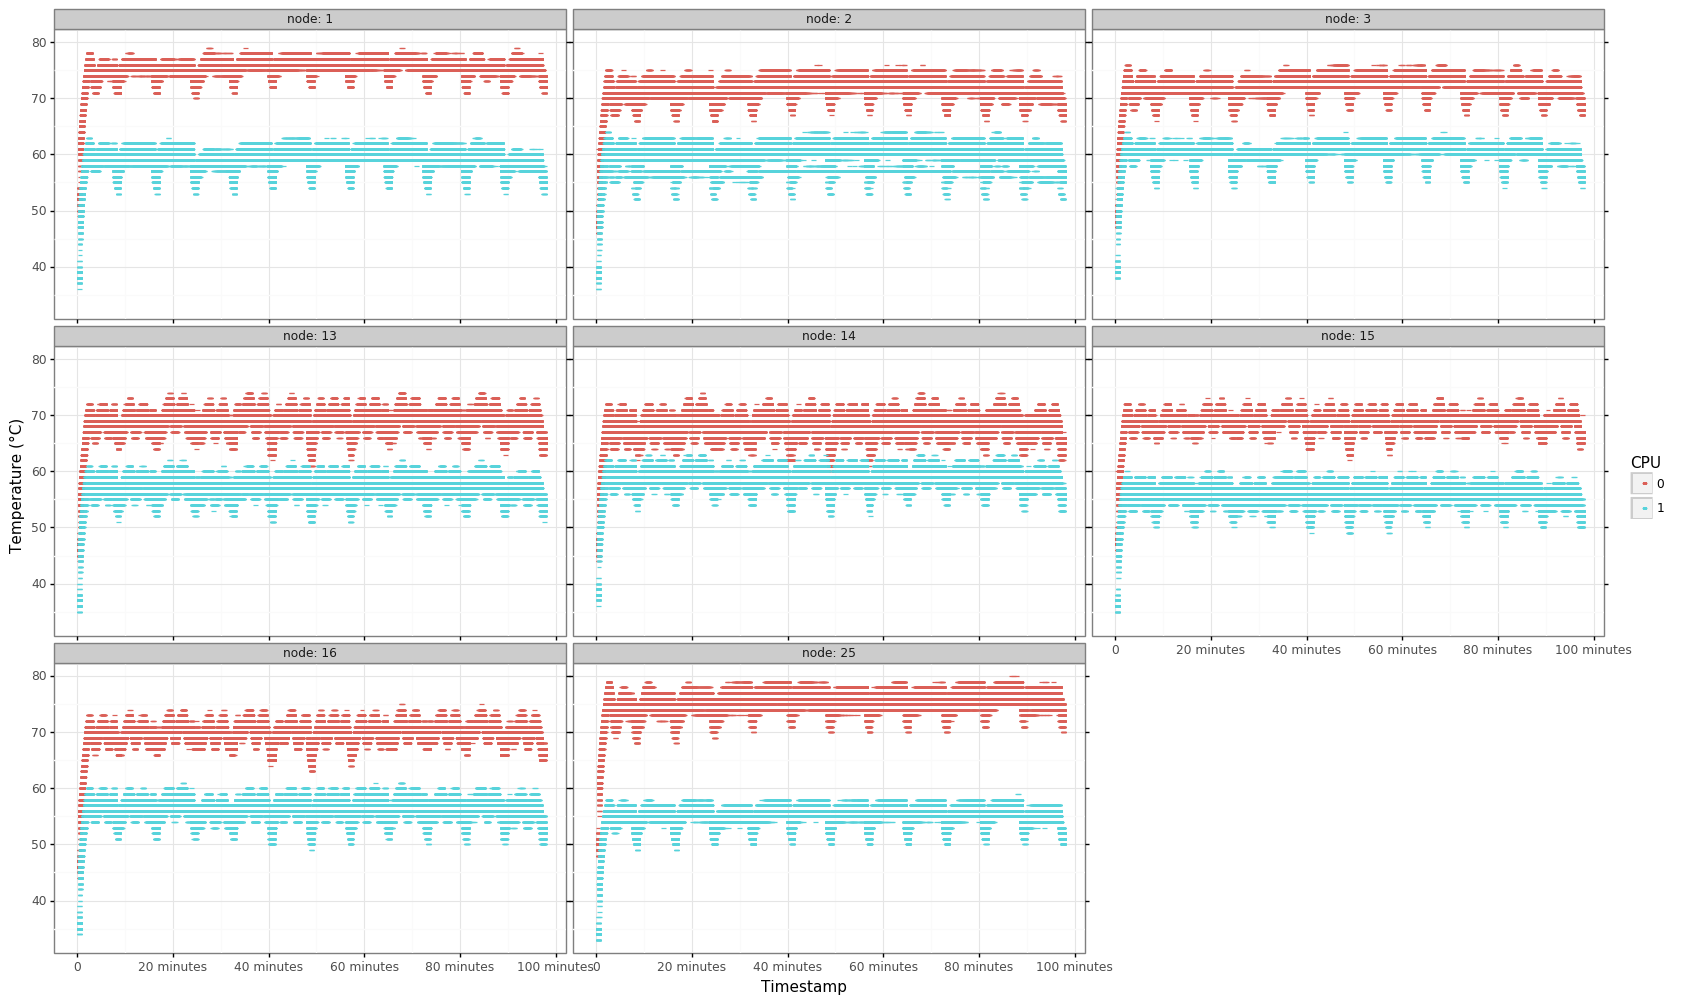

<ggplot: (8728512061532)>

In [12]:
plot = ggplot(temperature, aes(x='start', y='temperature_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='CPU')
plot

In [13]:
frequency = my_melt(monitoring, 'frequency_core_', ['hostname', 'start', 'node'])
frequency = frequency[frequency['group'] <= max(mapping.keys())]  # removing the cores with largest IDs (they are not real cores, just hyperthreads)
frequency['cpu'] = frequency.apply(lambda row: mapping[row.group], axis=1)
frequency['frequency_core_'] *= 1e-9
print(len(frequency))
frequency.head()

1481760


,hostname,start,node,frequency_core_,group,cpu
0,dahu-1.grenoble.grid5000.fr,00:00:00,1,2.887884,0,0
1,dahu-1.grenoble.grid5000.fr,00:00:01.006115,1,1.241363,0,0
2,dahu-1.grenoble.grid5000.fr,00:00:02.030784,1,1.541931,0,0
3,dahu-1.grenoble.grid5000.fr,00:00:03.109884,1,1.598840,0,0
4,dahu-1.grenoble.grid5000.fr,00:00:04.165958,1,1.579229,0,0


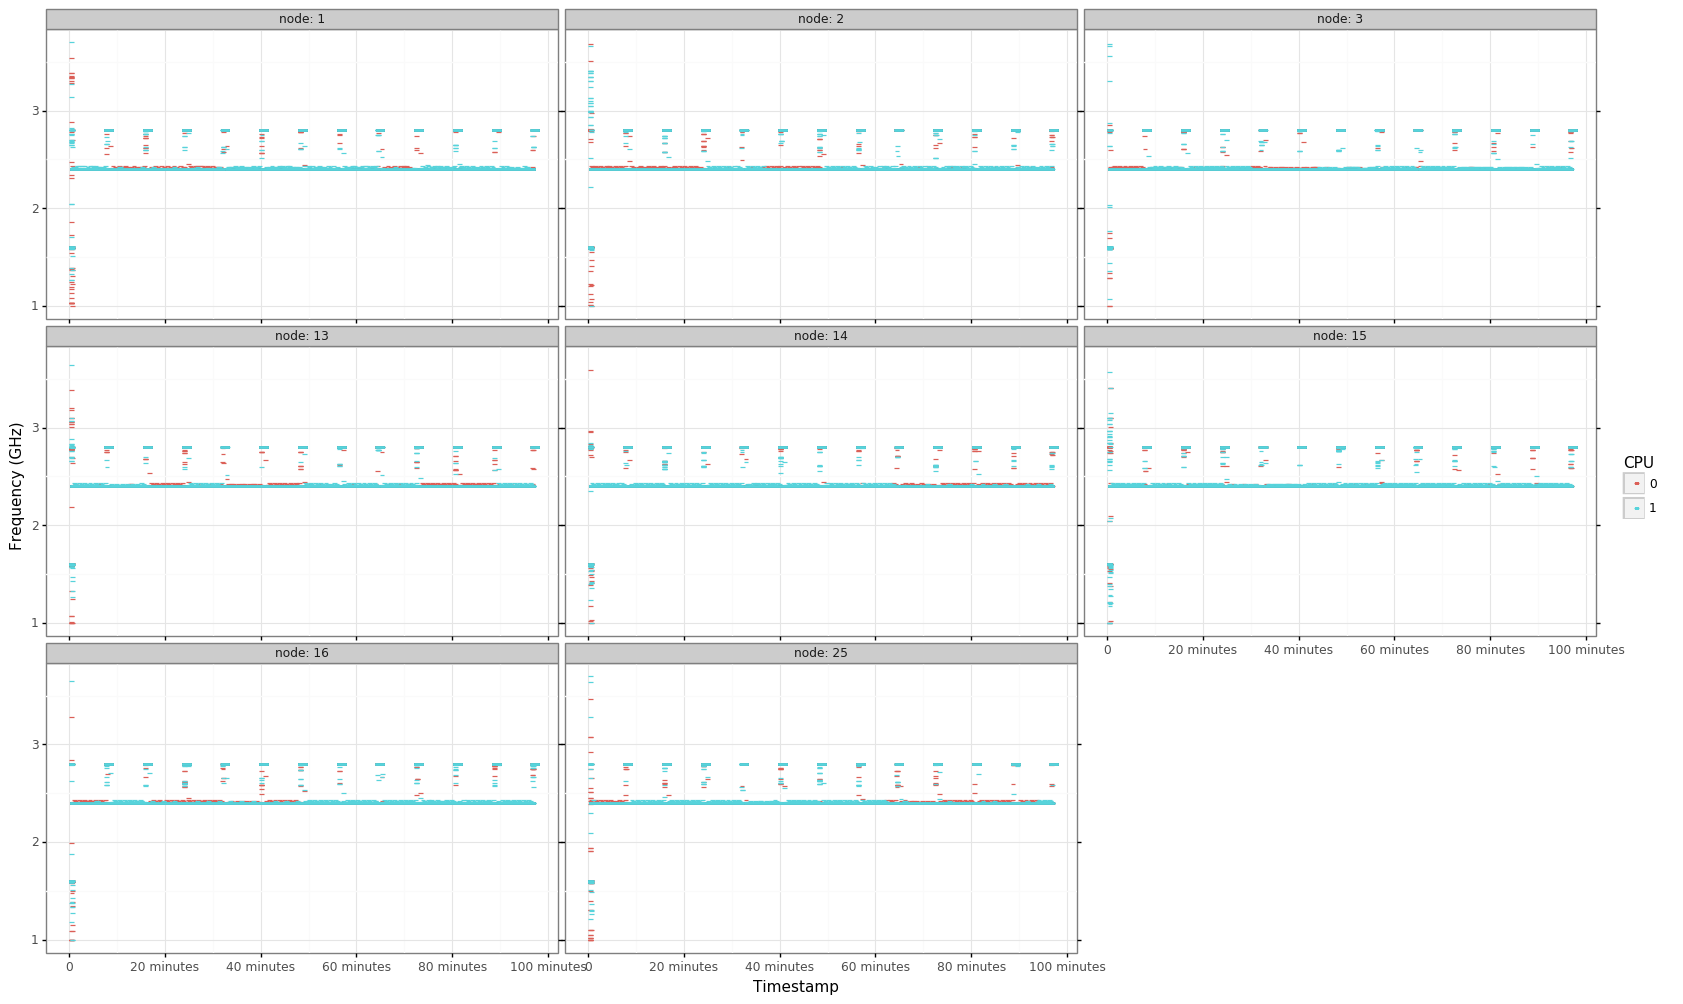

<ggplot: (-9223363308325586965)>

In [14]:
plot = ggplot(frequency, aes(x='start', y='frequency_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='CPU')
plot

In [15]:
frequency['frequency_core_'].describe()

count    1.481760e+06
mean     2.441353e+00
std      1.264566e-01
min      9.992430e-01
25%      2.399926e+00
50%      2.399926e+00
75%      2.399926e+00
max      3.699993e+00
Name: frequency_core_, dtype: float64